# Try models

In [141]:
import glob
import re
import pickle

import numpy as np
import pandas as pd
from isoweek import Week
from pandas_summary import DataFrameSummary
import itertools
import utils
import lightgbm as lgb
import random
import matplotlib.pyplot as plt, xgboost, operator, random, pickle
# from keras.models import model_from_yaml
from pandas_summary import DataFrameSummary
from importlib import reload
reload(utils)
import matplotlib

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)

import math
def rmsle(y_pred, targ):
    log_vars = np.log(targ + 1) - np.log(y_pred + 1)
    return math.sqrt(np.square(log_vars).mean())
def plot_impt(model):
    importance = model.get_fscore()
    importance = sorted(importance.items(), key=operator.itemgetter(1))

    df = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()

    df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance');
    # df[df.fscore < 0.009].feature.tolist()

def rmsle_wo_log(y_predicted, y_true):
    y_true = y_true.get_label()
    y_predicted_orig = utils.log_max_inv(y_predicted, max_log_y)
    y_true_orig = utils.log_max_inv(y_true, max_log_y)
    score = rmsle(y_predicted_orig, y_true_orig)
    return ('rmsle', score, False)

def rmsle_wo_log_sk(y_predicted, y_true):
    y_predicted_orig = utils.log_max_inv(y_predicted, max_log_y)
    y_true_orig = utils.log_max_inv(y_true, max_log_y)
    score = rmsle(y_predicted_orig, y_true_orig)
    return score
drop_vars = ['visit_date_month',
 'hpb_loc',
 'hpb_genre_name',
 'air_loc',
 'genre_name',
 'visit_date_week',
 'area_name',
 'air_store_id',
 'visit_date_dayofweek',
 'prop_yhat_lower',
 'prop_seasonal_upper',
 'max_visits_in_air_store_id',
 'af_holiday_flg',
 'prop_3_lower',
 'prop_3_upper',
 'prop_holidays_lower',
 'prop_seasonal_lower',
 'prop_weekly_upper',
 'prop_1',
 'prop_holidays_upper',
 'prop_2_lower',
 'min_visits_in_air_store_id',
 'prop_2_upper',
 'stores_in_area_name',
 'prop_trend_lower',
 'prop_3',
 'max_visits_in_area_name',
 'prop_6',
 'rolling_60d_median',
 'prop_yhat_upper',
 'prop_1_upper',
 'std_visits_in_air_store_id',
 'prop_6_lower',
 'prop_seasonalities_upper',
 'rolling_60d_std',
 'mean_visits_in_air_loc',
 'be_holiday_flg',
 'std_visits_in_air_loc',
 'prop_6_upper',
 'visit_date_ts',
 'prop_weekly_lower',
 'prop_trend',
 'prop_yhat',
 'rolling_60d_min',
 'prop_weekly',
 'prop_2',
 'prop_seasonal',
 'prop_seasonalities_lower',
 'prop_seasonalities',
 'rolling_60d_max',
 'prop_1_lower',
 'prop_trend_upper',
 'prop_holidays',
 'mean_visits_in_air_store_id',
             'visit_date', 
             'visitors', 
             'hpb_area_name', 'stores_in_air_loc',
       'stores_in_hpb_loc', 'stores_in_hpb_area_name', 'Date', 'holiday_flg',
       'dur_time_holiday_flg', 'dur_holiday_flg', 'dur_prog_holiday_flg',
       'prop_yhat', 
             'min_visits_in_air_loc', 'max_visits_in_air_loc',
       'min_visits_in_hpb_loc', 'max_visits_in_hpb_loc',
       'mean_visits_in_hpb_loc', 'std_visits_in_hpb_loc',
       'min_visits_in_area_name', 
             'mean_visits_in_area_name',
       'std_visits_in_area_name', 'min_visits_in_hpb_area_name',
       'max_visits_in_hpb_area_name', 'mean_visits_in_hpb_area_name',
       'std_visits_in_hpb_area_name', 'visit_date_year']

In [142]:


data_dir = r'./data'
trn = pd.read_csv('{}/air_visit_data.csv'.format(data_dir))



cat_vars = ['genre_name', 'air_store_id', 
            'hpb_genre_name','visit_date_year',
            'area_name'] # "air_store_id"
contin_vars = ['stores_in_hpb_loc',
               'stores_in_hpb_area_name',
               'stores_in_area_name',
               'stores_in_air_loc'] # 
precup_vars = ["prop_yhat", 
               "prop_yhat_lower", 
               "prop_yhat_upper",
              ]

keep_vars = cat_vars + contin_vars + precup_vars + ['visitors']

all_vars = cat_vars + contin_vars + precup_vars

drop_vars = list(set(drop_vars) - set(keep_vars))
feas = utils.data2fea(trn, data_dir, drop_vars=drop_vars)

In [143]:
input_map = feas['sk_fea']
y = feas['y']
tidy_data = feas['tidy_data']
all_vars = feas['all_vars']
cat_vars = feas['cat_vars']

In [144]:
cat_vars

['air_store_id',
 'area_name',
 'visit_date_year',
 'genre_name',
 'hpb_genre_name']

In [145]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, LabelBinarizer, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline

data_set = tidy_data[keep_vars]


def uniform(y_orig):
    max_log_y = np.max(np.log1p(y_orig))
    return np.log1p(y_orig) / max_log_y

def mat2fea(mat, cat_vars, contin_vars, precup_vars):
    " from feature dataframe to matrix based on type"
    mat[contin_vars] = mat[contin_vars].astype('float')
    for v in contin_vars:
        mat.loc[mat[v].isnull(), v] = 0
    for v in precup_vars:
        mat.loc[mat[v].isnull(), v] = 0
    for v in cat_vars:
        mat.loc[mat[v].isnull(), v] = ""
    
    if cat_vars:
        cat_maps = [(o, LabelEncoder()) for o in cat_vars]
        cat_mapper = DataFrameMapper(cat_maps)
        cat_map_fit = cat_mapper.fit(mat)
        cat_map = cat_map_fit.transform(mat).astype(np.int64)

#         mat[cat_vars] = cat_map
#         onehot_mapper = DataFrameMapper([
#             (['air_store_id'], OneHotEncoder())
#         ])
#         onehot_fit = onehot_mapper.fit(mat)
#         cat_map = onehot_fit.transform(mat)
    if contin_vars:
        contin_maps = [([o], StandardScaler()) for o in contin_vars]
        contin_mapper = DataFrameMapper(contin_maps)
        contin_map_fit = contin_mapper.fit(mat)
        contin_map = contin_map_fit.transform(mat).astype(np.float)
    # cat_map, 
    if precup_vars:
        precup_map = mat[precup_vars].apply(uniform).fillna(0).values
    return_vars = []
    if cat_vars: return_vars.append(cat_map)
    if contin_vars: return_vars.append(contin_map)
    if precup_vars: return_vars.append(precup_map)
    return np.concatenate(return_vars, axis=1), mat.visitors.values

X, Y = mat2fea(data_set, cat_vars, contin_vars, precup_vars)

# X, Y = data_set.prop_yhat.values, data_set.visitors
Y = Y[:].reshape(-1,1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log1p
  if __name__ == '__main__':
/Library/Frameworks

In [155]:
date_sr = pd.to_datetime(tidy_data.Date)
# data_range = [12]
# ntree_range = [32]
evals_result = {}

# for try_items in itertools.product(data_range, ntree_range):
data_i = 0
dat = utils.data_split_by_date(
    X, Y, date_sr, trn2val_ratio=9, step_days=500)
# valid & trn splitting
dat_d = dat[data_i]
X_train, y_train_orig, X_valid, y_valid_orig = dat_d['x_trn'], dat_d['y_trn'], dat_d['x_valid'], dat_d['y_valid']
y_train, y_valid, max_log_y = utils.uniform_y(y_train_orig, y_valid_orig)

data set: 1/1 train loss: 0.4891695065425423, valid loss: 0.4913065840046058


In [157]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train.ravel(), feature_name=all_vars, categorical_feature=cat_vars, free_raw_data=False)
lgb_eval = lgb.Dataset(X_valid, y_valid.ravel(), reference=lgb_train, free_raw_data=False)

In [158]:
# specify your configurations as a dict
params = {
    'task': 'train',
#     'boosting_type': 'dart',
    'objective': 'regression',
#     'metric': {'mse'},
    'num_leaves': 50,
    'learning_rate': 0.08,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'max_bin': 15,
    'max_depth': 40
}
evals_result = {} 
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=(lgb_train, lgb_eval),
                feval=rmsle_wo_log,
                evals_result=evals_result,
                ) # early_stopping_rounds=0

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/basic.py:1030: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/basic.py:1032: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['air_store_id', 'area_name', 'genre_name', 'hpb_genre_name', 'visit_date_year']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/Library/Frameworks/Python.framework/

[1]	training's rmsle: 0.767974	valid_1's rmsle: 0.764862
[2]	training's rmsle: 0.732304	valid_1's rmsle: 0.72969
[3]	training's rmsle: 0.700766	valid_1's rmsle: 0.698744
[4]	training's rmsle: 0.673076	valid_1's rmsle: 0.671454
[5]	training's rmsle: 0.648513	valid_1's rmsle: 0.647473
[6]	training's rmsle: 0.626867	valid_1's rmsle: 0.626427
[7]	training's rmsle: 0.608008	valid_1's rmsle: 0.607913
[8]	training's rmsle: 0.591775	valid_1's rmsle: 0.592339
[9]	training's rmsle: 0.577383	valid_1's rmsle: 0.578279
[10]	training's rmsle: 0.564849	valid_1's rmsle: 0.566303
[11]	training's rmsle: 0.554068	valid_1's rmsle: 0.555852
[12]	training's rmsle: 0.544682	valid_1's rmsle: 0.546998
[13]	training's rmsle: 0.536606	valid_1's rmsle: 0.539461
[14]	training's rmsle: 0.529587	valid_1's rmsle: 0.532952
[15]	training's rmsle: 0.523553	valid_1's rmsle: 0.527382
[16]	training's rmsle: 0.518356	valid_1's rmsle: 0.522557
[17]	training's rmsle: 0.513902	valid_1's rmsle: 0.518515
[18]	training's rmsle: 0

[143]	training's rmsle: 0.483982	valid_1's rmsle: 0.497786
[144]	training's rmsle: 0.483971	valid_1's rmsle: 0.497802
[145]	training's rmsle: 0.483961	valid_1's rmsle: 0.497816
[146]	training's rmsle: 0.483941	valid_1's rmsle: 0.497783
[147]	training's rmsle: 0.483927	valid_1's rmsle: 0.49778
[148]	training's rmsle: 0.483911	valid_1's rmsle: 0.497778
[149]	training's rmsle: 0.483899	valid_1's rmsle: 0.497789
[150]	training's rmsle: 0.483889	valid_1's rmsle: 0.497803
[151]	training's rmsle: 0.483877	valid_1's rmsle: 0.497797
[152]	training's rmsle: 0.483852	valid_1's rmsle: 0.497813
[153]	training's rmsle: 0.483841	valid_1's rmsle: 0.49783
[154]	training's rmsle: 0.48382	valid_1's rmsle: 0.497837
[155]	training's rmsle: 0.483794	valid_1's rmsle: 0.497854
[156]	training's rmsle: 0.48378	valid_1's rmsle: 0.497874
[157]	training's rmsle: 0.48377	valid_1's rmsle: 0.497884
[158]	training's rmsle: 0.483755	valid_1's rmsle: 0.497892
[159]	training's rmsle: 0.483739	valid_1's rmsle: 0.497904
[1

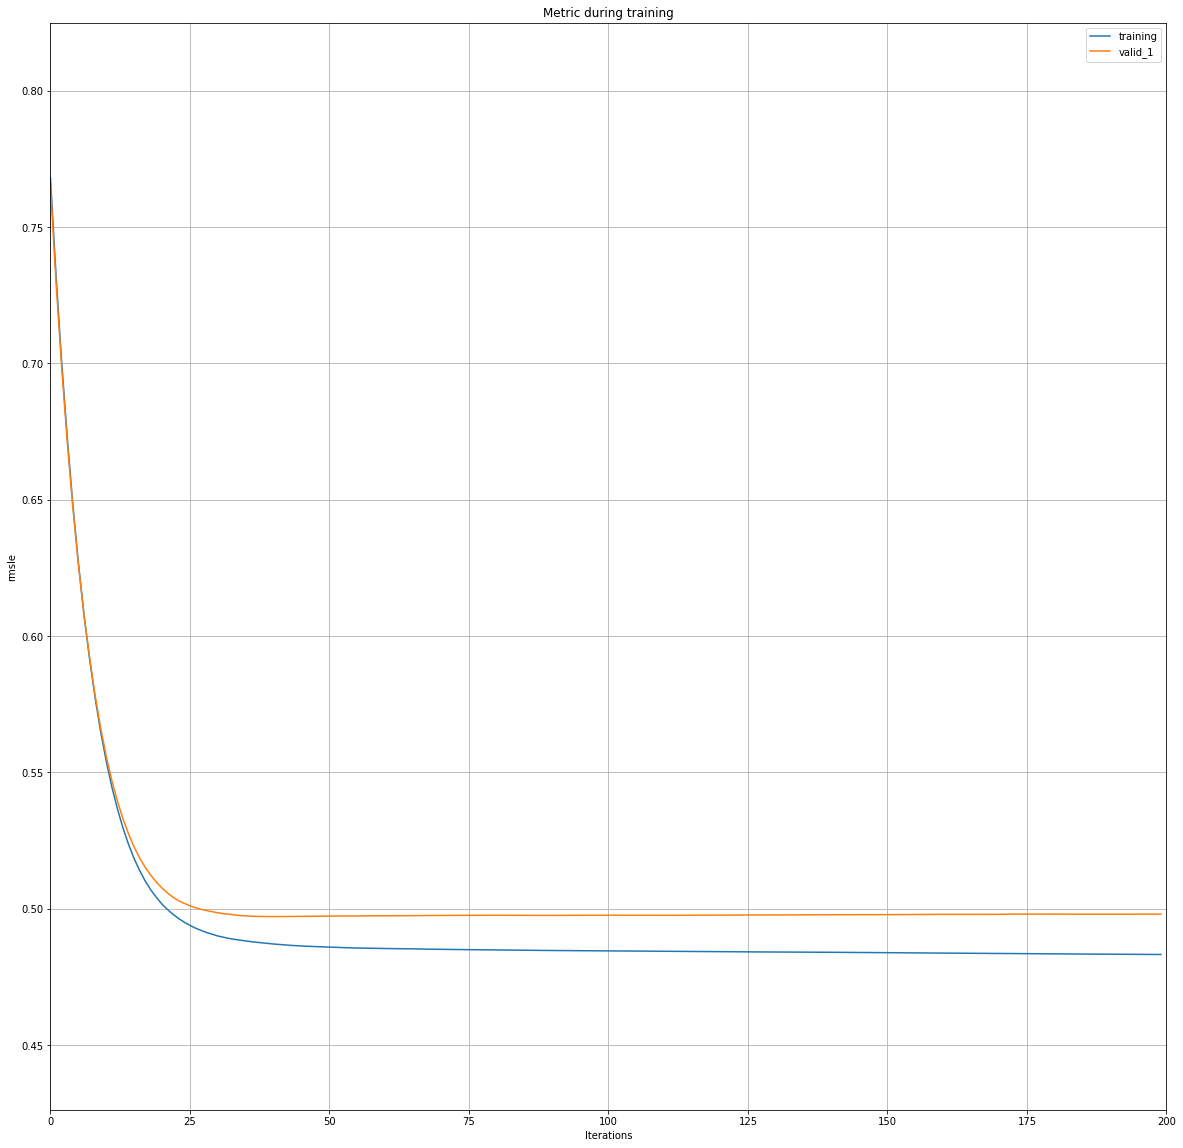

In [163]:
ax = lgb.plot_metric(evals_result, metric='rmsle')


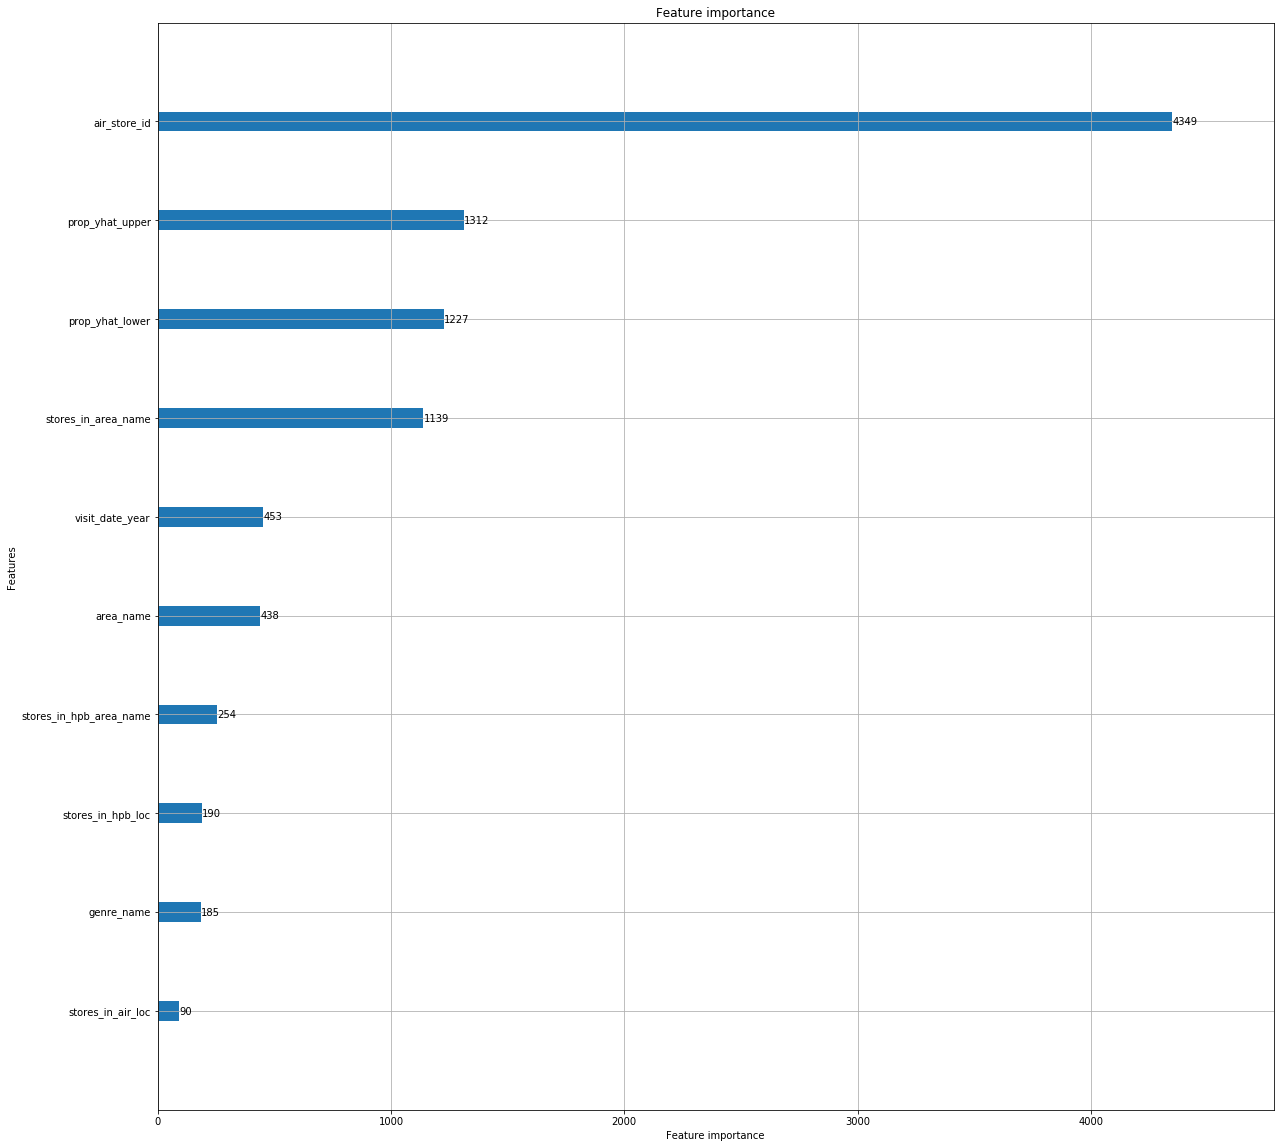

In [164]:
ax = lgb.plot_importance(gbm, max_num_features=10)


Linear Model train loss: 0.4891695065425423, valid loss: 0.4913065840046058
LightBGM train loss: 0.4832025257341087, valid loss: 0.4979987829613509


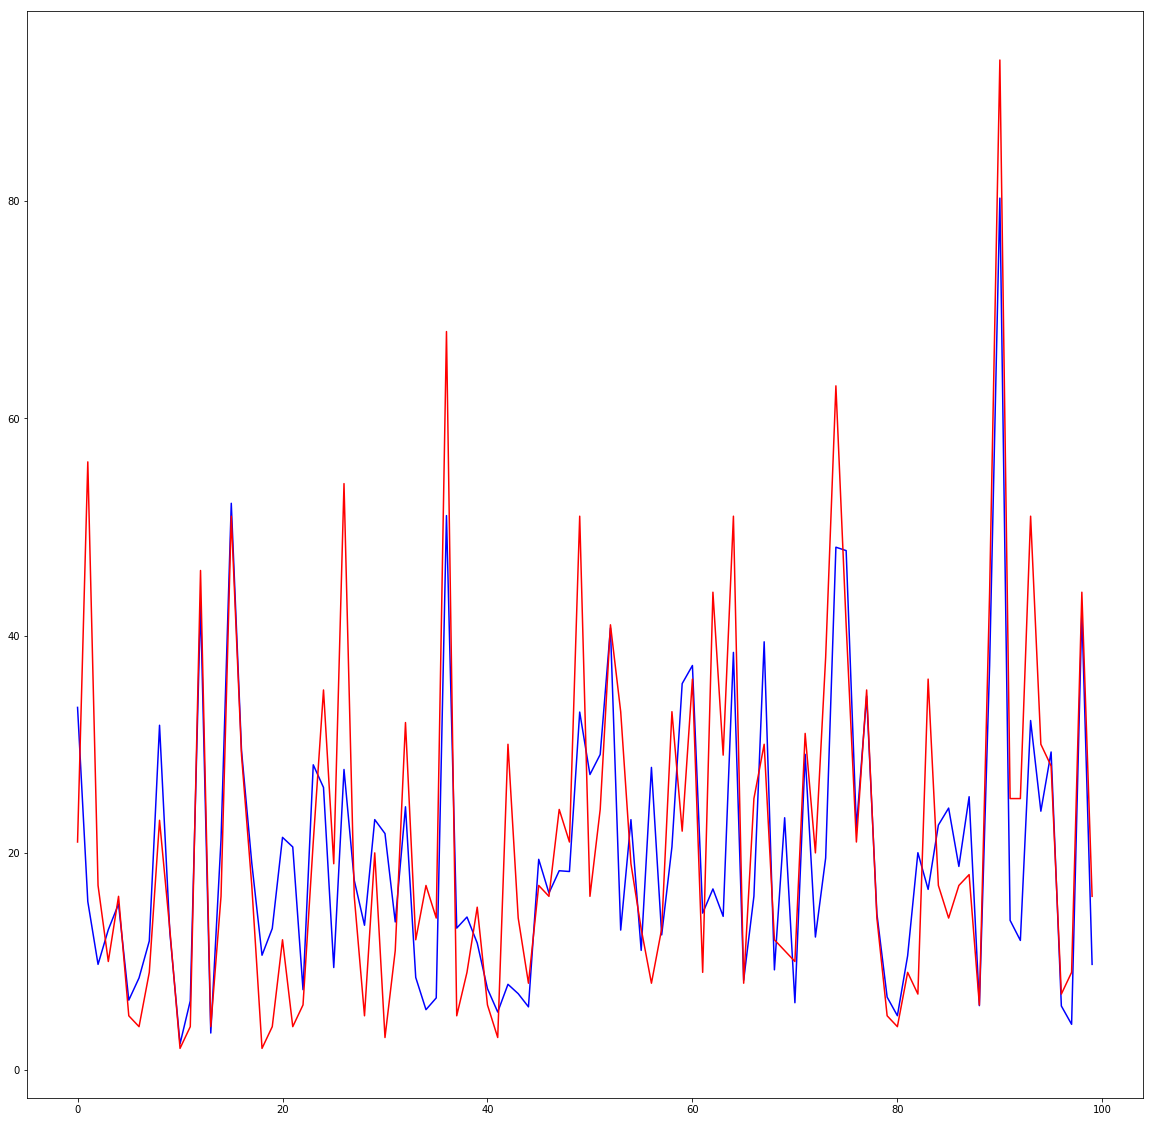

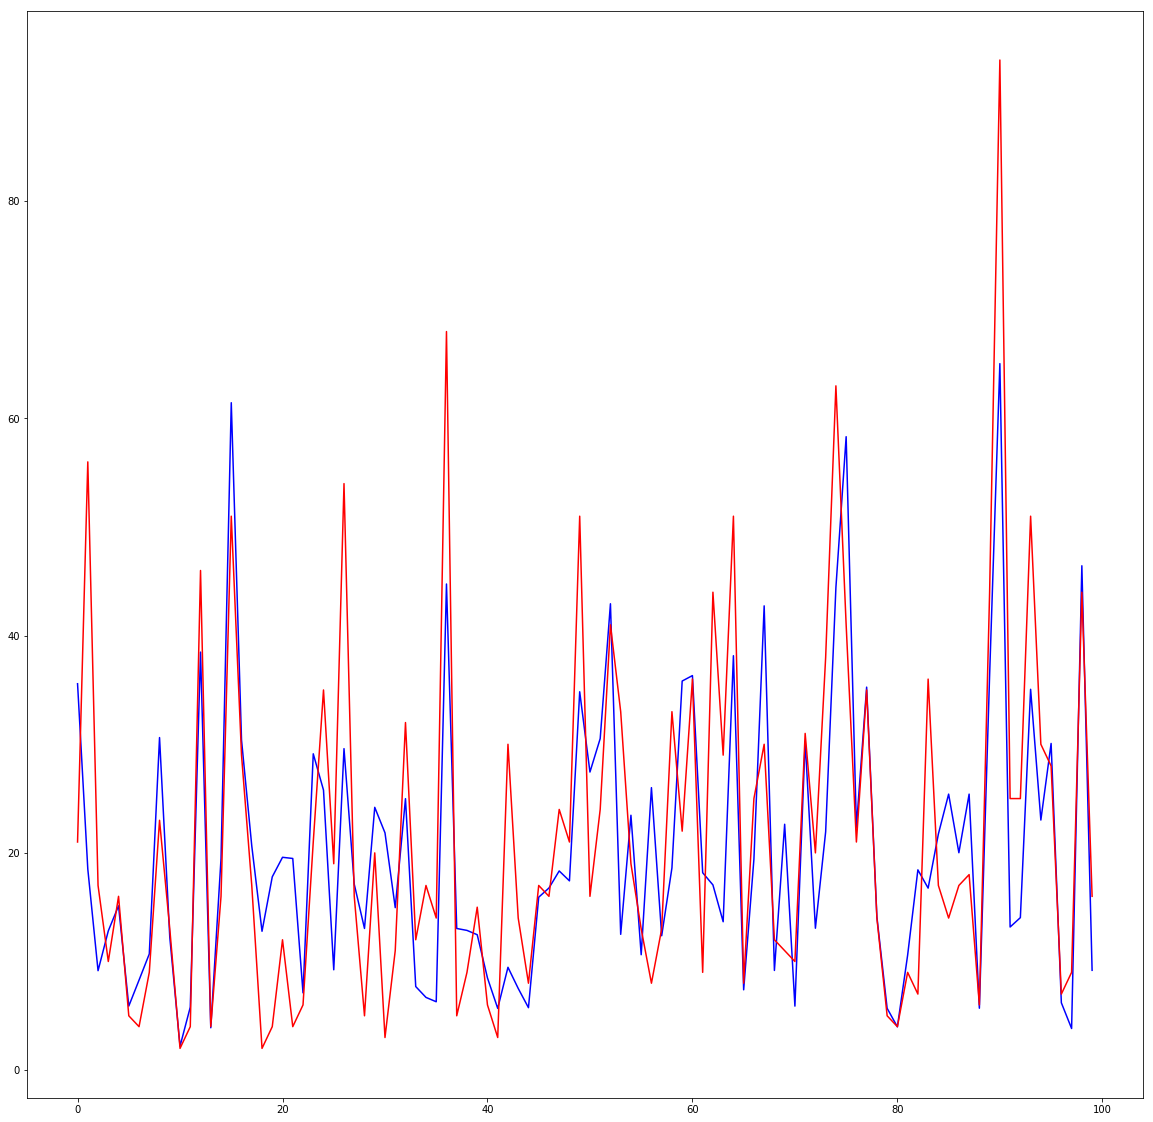

In [162]:
def verify_linear(X_train, y_train, y_valid_orig, y_train_orig, max_log_y):
    from sklearn import linear_model

    reg = linear_model.LinearRegression()
    reg.fit(X_train, y_train)
    pred_valid = reg.predict(X_valid)
    pred_valid_orig = utils.log_max_inv(pred_valid, max_log_y)
    # pred_valid_orig = pred_valid
    valid_loss = rmsle(pred_valid_orig, y_valid_orig)
    pred_trn = reg.predict(X_train)
    pred_trn_orig = utils.log_max_inv(pred_trn, max_log_y)
    # pred_trn_orig = pred_trn
    trn_loss = rmsle(pred_trn_orig, y_train_orig)
    plt.figure(1)
    plt.plot(pred_valid_orig[:100], c='b')
    plt.plot(y_valid_orig[:100], c='r')
    print('Linear Model train loss: {}, valid loss: {}'.format( trn_loss, valid_loss))
verify_linear(X_train, y_train, y_valid_orig, y_train_orig, max_log_y)



# split_point = X.shape[0] - y_valid_orig.ravel().shape[0]
# base_line = rmsle(tidy_data['prop_yhat'].values[split_point:].ravel(), y_valid_orig.ravel())

pred_valid = gbm.predict(X_valid)
pred_valid_orig = utils.log_max_inv(pred_valid, max_log_y)
valid_loss = rmsle(pred_valid_orig, y_valid_orig.ravel())
pred_trn = gbm.predict(X_train)
pred_trn_orig = utils.log_max_inv(pred_trn, max_log_y)
trn_loss = rmsle(pred_trn_orig, y_train_orig.ravel())
print('LightBGM train loss: {}, valid loss: {}'.format(trn_loss, valid_loss))

plt.figure(2)
plt.plot(pred_valid_orig[:100], c='b')
plt.plot(y_valid_orig[:100], c='r')

In [95]:
tidy_data['prop_yhat'].values[split_point:].ravel()

array([ 11.65694164,  18.70591151,  15.29806426, ...,  36.56844755,
        14.32641414,   5.25283941])

In [96]:
y_valid_orig.ravel()

array([21, 56, 17, ...,  7, 15,  5])

In [97]:
rmsle(tidy_data['prop_yhat'].values[split_point:].ravel(), y_valid_orig.ravel())

1.047368603758247